# 8장. 핵심 키워드 추출 (Keyword Extraction)

# 8-0 데이터 준비

## Mecab 설치 (필요시)

In [ ]:
!sudo apt-get install g++ openjdk-7-jdk # Install Java 1.7+
!sudo apt-get install python-dev; pip install konlpy     # Python 2.x
!sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package openjdk-7-jdk is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'openjdk-7-jdk' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-dev is already the newest version (2.7.15~rc1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 7.6MB/s 
     |████████████████████████████████| 3.6MB 36.3MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing inst

# 8-1 TF-IDF 활용 핵심키워드 추출

## 실습 1. sklearn 활용


In [ ]:
import requests 
from bs4 import BeautifulSoup

def get_news_by_url(url):
  res = requests.get(url)
  bs = BeautifulSoup(res.content, 'html.parser')

  title = bs.select('h3#articleTitle')[0].text #제목
  content = bs.select('#articleBodyContents')[0].get_text().replace('\n', " ") #본문
  content = content.replace("// flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}", "")
  return  content.strip()

docs = []
docs.append( get_news_by_url('https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=018&aid=0004430108') )
docs.append( get_news_by_url('https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=001&aid=0011614790') )
docs.append( get_news_by_url('https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=014&aid=0004424362') )
docs.append( get_news_by_url('https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=119&aid=0002402191') )
docs.append( get_news_by_url('https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=030&aid=0002882728') )
len(docs)

5

### 1) 전처리

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

preprocessed_docs = []
for doc in docs :
  # 명사와 동사만으로 문서 전처리
  preprocessed_docs.append(' '.join([token[0] for token in mecab.pos(doc) if token[1][0] in ['N', 'V']]))
preprocessed_docs[0][:100]

'과기 정통부 일 유영민 장관 등 참석 기념행사 년 억 원 투입 여종 데이터 구축 민간 클라우드 통한 외부 연계 체계 개방 강화 데일리 이재운 기자 국가 차원 빅 데이터 활용 시대 '

### 2) TF-IDF 계산

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_df=0.85, max_features=10000)
word_count_vector = count_vectorizer.fit_transform(preprocessed_docs)
list(count_vectorizer.vocabulary_.keys())[:10]

['과기', '정통부', '유영민', '장관', '참석', '기념행사', '투입', '여종', '구축', '민간']

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

### 3) 핵심키워드 추출

In [ ]:
def sort_keywords(keywords):
    return sorted(zip(keywords.col, keywords.data), key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_keywords(feature_names, sorted_keywords, n=5):
    return [(feature_names[idx], score) for idx, score in sorted_keywords[:n]]

In [ ]:
doc = preprocessed_docs[0] # 핵심키워드 추출할 문서 조회

feature_names = count_vectorizer.get_feature_names() # TF-IDF 단어 목록
tf_idf_vector = tfidf_transformer.transform(count_vectorizer.transform([doc])) # 문서의 tf-idf 추출
sorted_keywords = sort_keywords(tf_idf_vector.tocoo()) # TF-IDF를 기준으로 역순 정렬
 
# 사용자가 지정한 갯수만큼 키워드 추출
keywords = extract_keywords(feature_names, sorted_keywords, 5)
 
print("\n===== 원문 =====")
print(docs[0][:100])
print("\n=== 핵심키워드 ===")
for k in keywords:
    print(k)


===== 원문 =====
과기정통부, 22일 유영민 장관 등 참석해 기념행사2021년까지 1516억원 투입, 5100여종 데이터 구축민간 클라우드 통한 외부연계체계도.."개방성 강화"[이데일리 이재운 기자

=== 핵심키워드 ===
('플랫', 0.2526148007071733)
('계획', 0.21652697203472)
('정통부', 0.18043914336226666)
('과기', 0.18043914336226666)
('통해', 0.17469259767293158)


In [ ]:
tf_idf_vector.tocoo().data

array([0.03608783, 0.03608783, 0.05823087, 0.07217566, 0.03608783,
       0.03608783, 0.03608783, 0.02911543, 0.03608783, 0.14557716,
       0.03608783, 0.03608783, 0.02911543, 0.02911543, 0.07217566,
       0.11646173, 0.03608783, 0.03608783, 0.04833688, 0.03608783,
       0.03608783, 0.2526148 , 0.03608783, 0.02911543, 0.03608783,
       0.02911543, 0.02911543, 0.03608783, 0.10826349, 0.1746926 ,
       0.07217566, 0.03608783, 0.10826349, 0.03608783, 0.07217566,
       0.03608783, 0.02911543, 0.02911543, 0.07217566, 0.03608783,
       0.04066251, 0.02911543, 0.07217566, 0.03608783, 0.03608783,
       0.10826349, 0.03608783, 0.03608783, 0.10826349, 0.03608783,
       0.03608783, 0.02911543, 0.03608783, 0.03608783, 0.02911543,
       0.02911543, 0.03608783, 0.03608783, 0.10826349, 0.02911543,
       0.07217566, 0.03608783, 0.02911543, 0.03608783, 0.1208422 ,
       0.07217566, 0.18043914, 0.02911543, 0.04066251, 0.02911543,
       0.09667376, 0.07217566, 0.03608783, 0.02033125, 0.02911


---


## 실습 2. gensim 활용


### 1) 전처리

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

preprocessed_docs = []
for doc in docs :
  # 명사와 동사만으로 문서 전처리
  preprocessed_docs.append(' '.join([token[0] for token in mecab.pos(doc) if token[1][0] in ['N', 'V']]))
preprocessed_docs[0][:100]

'과기 정통부 일 유영민 장관 등 참석 기념행사 년 억 원 투입 여종 데이터 구축 민간 클라우드 통한 외부 연계 체계 개방 강화 데일리 이재운 기자 국가 차원 빅 데이터 활용 시대 '

### 2) TF-IDF 계산

In [ ]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

document_ls = [doc.split() for doc in preprocessed_docs]
dct = Dictionary(document_ls) # 인덱스(key) - 단어(valuue) 인 딕셔너리 생성
corpus = [dct.doc2bow(doc) for doc in document_ls] # 각 문서에 포함된 단어를 인덱스로 변환하여 corpus 생성
tfidf = TfidfModel(corpus) # TF-IDF 산출

### 3) 핵심키워드 추출

In [ ]:
def sort_keywords(tfidf):
    return sorted(tfidf, key=lambda x: (x[1], x[0]), reverse=True)

def extract_keywords(feature_names, sorted_keywords, n=5):
    return [(feature_names[idx], score) for idx, score in sorted_keywords[:n]]

In [ ]:
doc = corpus[0]

sorted_keywords = sort_keywords(tfidf[doc]) # TF-IDF를 기준으로 역순 정렬

# 사용자가 지정한 갯수만큼 키워드 추출
keywords = extract_keywords(dct, sorted_keywords, 5)

print("\n=== 핵심키워드 ===")
for k in keywords:
    print(k)


=== 핵심키워드 ===
('플랫', 0.260111262735105)
('폼', 0.260111262735105)
('계획', 0.2229525109158043)
('정통부', 0.18579375909650356)
('과기', 0.18579375909650356)


In [ ]:
tfidf[doc]

[(0, 0.021155348483460852),
 (1, 0.011793957648078673),
 (3, 0.023587915296157346),
 (4, 0.021155348483460852),
 (5, 0.037158751819300714),
 (6, 0.037158751819300714),
 (7, 0.037158751819300714),
 (8, 0.036063616033346915),
 (9, 0.06346604545038255),
 (10, 0.037158751819300714),
 (11, 0.042310696966921704),
 (12, 0.021155348483460852),
 (13, 0.037158751819300714),
 (14, 0.021155348483460852),
 (15, 0.037158751819300714),
 (16, 0.021155348483460852),
 (17, 0.005151945147620987),
 (18, 0.07431750363860143),
 (19, 0.10577674241730427),
 (20, 0.037158751819300714),
 (21, 0.2229525109158043),
 (22, 0.037158751819300714),
 (23, 0.010303890295241975),
 (24, 0.037158751819300714),
 (25, 0.07431750363860143),
 (26, 0.037158751819300714),
 (27, 0.011793957648078673),
 (28, 0.037158751819300714),
 (29, 0.18579375909650356),
 (30, 0.042310696966921704),
 (31, 0.037158751819300714),
 (32, 0.042310696966921704),
 (33, 0.07431750363860143),
 (34, 0.011793957648078673),
 (35, 0.037158751819300714),
 (



---



# 8-2 Textrank
https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf

<img src="https://3.bp.blogspot.com/-yp0Lr3ec5EY/XIs6znCcO_I/AAAAAAAAAPY/xtZxe_OYtH0xeuWsp4Qd4DQrunGMpVQmQCLcBGAs/s640/keyword-extraction-textrank.png" />

## 실습 1. 행렬 활용 


### 1) 토큰화 (Tokenization)

분석 텍스트 정제

### 2) Unique한 토큰 목록 생성

그래프 생성을 위해서 Unique한 토큰 목록 생성

In [147]:
token = ['딸기', '바나나', '사과', '딸기', '파인애플']
nodes = ['바나나', '사과', '파인애플', '딸기']
vocab = nodes

vocab2idx = None #vocab을 인덱스로 변환
idx2vocab = None  #인덱스를 vocab으로 변환


In [148]:
from collections import defaultdict

vocab2idx = defaultdict(lambda: len(vocab2idx))
[vocab2idx[token] for token in vocab]
vocab2idx


defaultdict(<function __main__.<lambda>>,
            {'딸기': 3, '바나나': 0, '사과': 1, '파인애플': 2})

In [149]:
vocab2idx.items()

dict_items([('바나나', 0), ('사과', 1), ('파인애플', 2), ('딸기', 3)])

In [150]:
for i in vocab2idx:
  print(i)

바나나
사과
파인애플
딸기


In [151]:
idx2vocab = {}

for key in vocab2idx:
  for i in range(len(vocab)):
    if vocab2idx[key] == i:
      idx2vocab[i] = key
idx2vocab

{0: '바나나', 1: '사과', 2: '파인애플', 3: '딸기'}

### 3) 그래프 생성 (weighted edge 계산)

*   TextRank는 그래프 기반 모델
*   각 단어(토큰)은 그래프의 노드(vertex) 
*   weighted_edge 행렬은 노드간 가중치 정보를 담고 있음
*   weighted_edge[i][j] 는 i번째 단어와 j번째 단어의 가중치를 의미
*   weighted_edge[i][j] 가 0인 경우는 노드간 연결이 없음을 의미
*   모든 노드는 1로 초기화

In [152]:
token = ['딸기', '바나나', '사과', '딸기', '파인애플']
nodes = ['바나나', '사과', '파인애플', '딸기']

In [153]:
np.zeros?

In [154]:
a = [2, 1]
a[::-1]

[1, 2]

In [345]:
import numpy as np
import math
vocab_len = len(vocab)

# 토큰별로 그래프 edge를 Matrix 형태로 생성
weighted_edge = np.zeros((vocab_len, vocab_len))

# 각 토큰 노드별로 스코어 1로 초기화
score = np.ones((vocab_len))

# coocurrence를 판단하기 위한 window 사이즈 설정
window_size = 2
covered_coocurrences = np.zeros((vocab_len, vocab_len))
index_list = []

for start_point in range(len(token)-window_size+1):
  window = token[start_point:start_point+window_size]
  w_cor = []
  index_cor = ()
  for w in window:
    w_cor.append(vocab2idx[w])

  for i in range(window_size-1):
    for j in range(i+1,window_size):
      index_cor = w_cor[i], w_cor[j]

      if index_cor not in index_list:
        index_list.append(index_cor)
        index_list.append(index_cor[::-1])


index_list
# weighted_edge 구현
for cor in index_list:
  i = cor[0]
  j = cor[1]
  covered_coocurrences[i, j] =1
print(covered_coocurrences)
for i in range(len(covered_coocurrences)):
  new = covered_coocurrences[i] / sum(covered_coocurrences[i])
  weighted_edge[i] = new
weighted_edge



[[0. 1. 0. 1.]
 [1. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 1. 1. 0.]]


array([[0.        , 0.5       , 0.        , 0.5       ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ]])

### 4) 각 노드의 score계산
각 노드와 연결된 weighted edge의 값을 합산

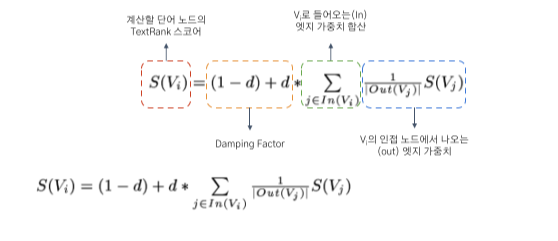

In [250]:
weighted_edge[:,1]*score

array([0.42916667, 0.        , 0.        , 0.61666667])

In [310]:
for i in range(vocab_len):
  new_edge = weighted_edge[:,i]*score
  weighted_edge[:,i] = new_edge 
  print(new_edge)

weighted_edge

[0.         0.5        0.         0.33333333]
[0.5        0.         0.         0.33333333]
[0.         0.         0.         0.33333333]
[0.5 0.5 1.  0. ]


array([[0.        , 0.5       , 0.        , 0.5       ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ]])

In [341]:
sum(weighted_edge)

array([0.83333333, 0.83333333, 0.33333333, 2.        ])

In [347]:
MAX_ITERATIONS = 50
d=0.85
threshold = 0.0001 #convergence threshold

for iter in range(0,MAX_ITERATIONS):
  prev_score = np.copy(score)

  if np.sum(np.fabs(prev_score - score)) <= threshold:
            break
    
  weight_sum = sum(weighted_edge)
  for i in range(vocab_len):
    score[i] = (1-d) + d*weight_sum[i]
    print(score[i])

  for i in range(vocab_len):
    new_edge = weighted_edge[:,i]*score
    weighted_edge[:,i] = new_edge 

score

array([1., 1., 1., 1.])

### 5) 핵심 단어 추출

In [ ]:
sorted_index = None

n = 4

print("\n=== 핵심키워드 ===")
for i in range(0,n):
    print(str(idx2vocab[sorted_index[i]])+" : " + str(score[sorted_index[i]]))


=== 핵심키워드 ===
딸기 : 1.4668667
사과 : 0.98365426
바나나 : 0.98364776
파인애플 : 0.5656039


In [ ]:
sorted_index[0]

3

---

## 쌤 ver

### 1) 토큰화 (Tokenization)

분석 텍스트 정제

### 2) Unique한 토큰 목록 생성

그래프 생성을 위해서 Unique한 토큰 목록 생성

In [317]:
token = ['딸기', '바나나', '사과', '딸기', '파인애플']
nodes = ['바나나', '사과', '파인애플', '딸기']
vocab = nodes

vocab2idx = {vocab[i] : i for i in range(len(vocab))} #vocab을 인덱스로 변환
idx2vocab = {i: vocab[i] for i in range(len(vocab))}

vocab2idx

{'딸기': 3, '바나나': 0, '사과': 1, '파인애플': 2}

### 3) 그래프 생성 (weighted edge 계산)

*   TextRank는 그래프 기반 모델
*   각 단어(토큰)은 그래프의 노드(vertex) 
*   weighted_edge 행렬은 노드간 가중치 정보를 담고 있음
*   weighted_edge[i][j] 는 i번째 단어와 j번째 단어의 가중치를 의미
*   weighted_edge[i][j] 가 0인 경우는 노드간 연결이 없음을 의미
*   모든 노드는 1로 초기화

In [323]:
import numpy as np
import math
vocab_len = len(vocab)

# 토큰별로 그래프 edge를 Matrix 형태로 생성
weighted_edge = np.zeros((vocab_len, vocab_len))

# 각 토큰 노드별로 스코어 1로 초기화
score = np.ones((vocab_len))

# coocurrence를 판단하기 위한 window 사이즈 설정
window_size = 2
covered_coocurrences = []

# weighted_edge 구현
for window_start in range(len(token) - window_size + 1):
  window = token[window_start : window_start + window_size]
  for i in range(window_size):
    for j in range(i+1, window_size):

      if (window[i] in vocab2idx.keys() and window[j] in vocab2idx.keys()):
        index_i = window_start + i
        index_j = window_start + j

        if [index_i, index_j] not in covered_coocurrences:
          weighted_edge[vocab2idx[window[i]]][vocab2idx[window[j]]] = 1
          weighted_edge[vocab2idx[window[j]]][vocab2idx[window[i]]] = 1
          covered_coocurrences.append((index_i, index_j))

for i in range(vocab_len):
  sum_i = weighted_edge[i].sum()
  weighted_edge[i] = weighted_edge[i] / sum_i if sum_i > 0 else 0




weighted_edge

array([[0.        , 0.5       , 0.        , 0.5       ],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ]])

### 4) 각 노드의 score계산
각 노드와 연결된 weighted edge의 값을 합산

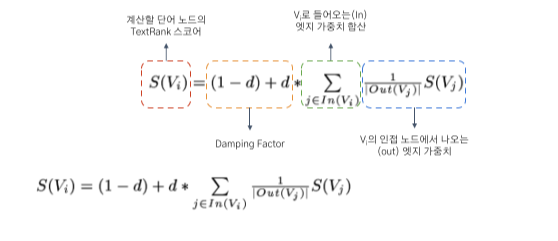

In [332]:
MAX_ITERATIONS = 50
d=0.85
threshold = 0.0001 #convergence threshold

for iter in range(0,MAX_ITERATIONS):
    prev_score = np.copy(score)
    
    for i in range(vocab_len):
      summation = 0 
      for j in range(len(vocab)):
        if weighted_edge[j][i] != 0:
          summation += weighted_edge[j][i] * score[j]

          score[i] = (1-d) + d*summation

        if np.sum(np.fabs(prev_score - score)) <= threshold:
          break
        #np.fabs: element끼리 연산시키기 
score

array([1.        , 0.99497974, 0.56990005, 1.48228143])

### 5) 핵심 단어 추출

In [344]:
sorted_index = (np.argsort(score)[::-1])

print("\n=== 핵심키워드 ===")
for i in range(0,4):
    print(str(idx2vocab[sorted_index[i]])+" : " + str(score[sorted_index[i]]))


=== 핵심키워드 ===
딸기 : 1.0
파인애플 : 1.0
사과 : 1.0
바나나 : 1.0


## 쌤ver

In [ ]:
import requests 
from bs4 import BeautifulSoup

def get_news_by_url(url):
  res = requests.get(url)
  bs = BeautifulSoup(res.content, 'html.parser')

  title = bs.select('h3#articleTitle')[0].text #제목
  content = bs.select('#articleBodyContents')[0].get_text().replace('\n', " ") #본문
  content = content.replace("// flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}", "")
  return  content.strip()

doc = get_news_by_url('https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=018&aid=0004430108')
doc[:50]

'과기정통부, 22일 유영민 장관 등 참석해 기념행사2021년까지 1516억원 투입, 510'

### 1) 토큰화 (Tokenization)

분석 텍스트 정제

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

nodes = [token for token in mecab.pos(doc) if token[1] in ['NNG','NNP']] #NNG, NNP를 스코어 계산 대상(노드)로 제한
tokens = [token for token in mecab.pos(doc)] #탐색할 토큰 전체

### 2) 그래프 생성 (weighted edge 계산)

### 3) 각 노드의 score계산

### 4)핵심 단어 추출